# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [49]:
# Import numpy and pandas
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from pandas.plotting import lag_plot
from pylab import rcParams

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tools.eval_measures import rmse

# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [3]:
# Run this code
sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [4]:
# Your code here:
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [5]:
# There are no rows containing missing data.
sensor.isnull().sum()

attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

How many rows and columns are in our data?

In [8]:
# Your code here:
rows, columns = sensor.shape
print('There are {} rows and {} columns in the sensor data.'.format(rows, columns))

There are 1751 rows and 12 columns in the sensor data.


To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [9]:
# Your code here:
periods = sensor.shape[0]
start='1/1/2018 00:00:00'
end='1/1/2018 00:29:10'

Assign the time series index to the dataframe's index.

In [10]:
# Your code here:
sensor.index = pd.date_range(start, end, periods) 
sensor.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:00:01',
               '2018-01-01 00:00:02', '2018-01-01 00:00:03',
               '2018-01-01 00:00:04', '2018-01-01 00:00:05',
               '2018-01-01 00:00:06', '2018-01-01 00:00:07',
               '2018-01-01 00:00:08', '2018-01-01 00:00:09',
               ...
               '2018-01-01 00:29:01', '2018-01-01 00:29:02',
               '2018-01-01 00:29:03', '2018-01-01 00:29:04',
               '2018-01-01 00:29:05', '2018-01-01 00:29:06',
               '2018-01-01 00:29:07', '2018-01-01 00:29:08',
               '2018-01-01 00:29:09', '2018-01-01 00:29:10'],
              dtype='datetime64[ns]', length=1751, freq=None)

Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

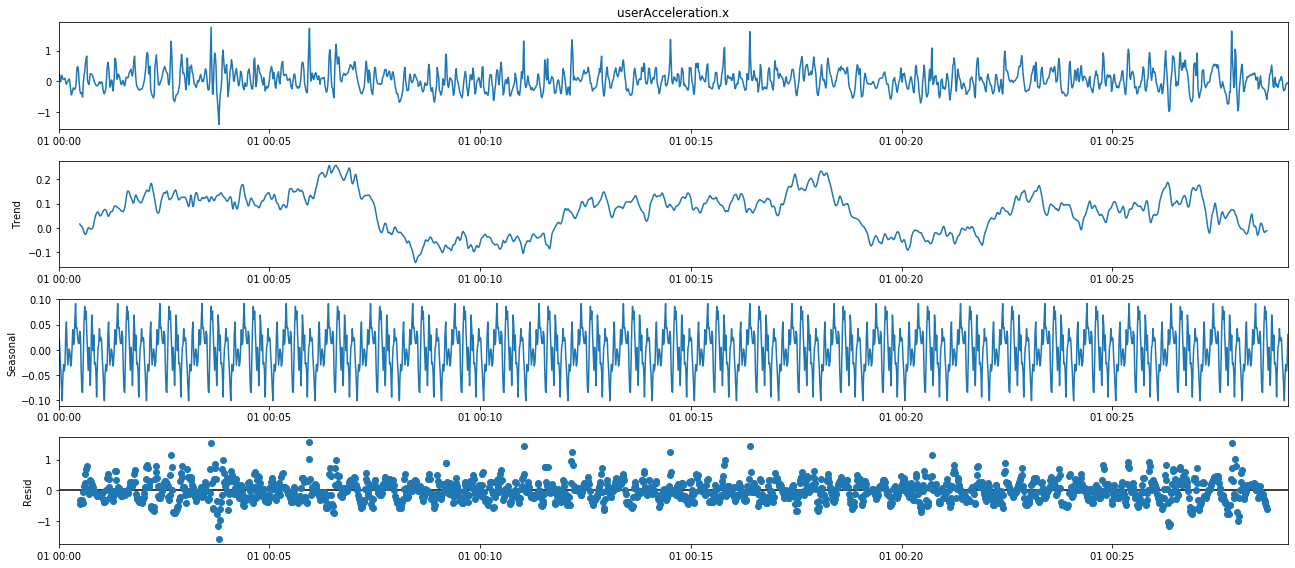

In [27]:
# Your code here:
rcParams['figure.figsize'] = 18, 8

res = sm.tsa.seasonal_decompose(sensor['userAcceleration.x'], freq=60)
resplot = res.plot()

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

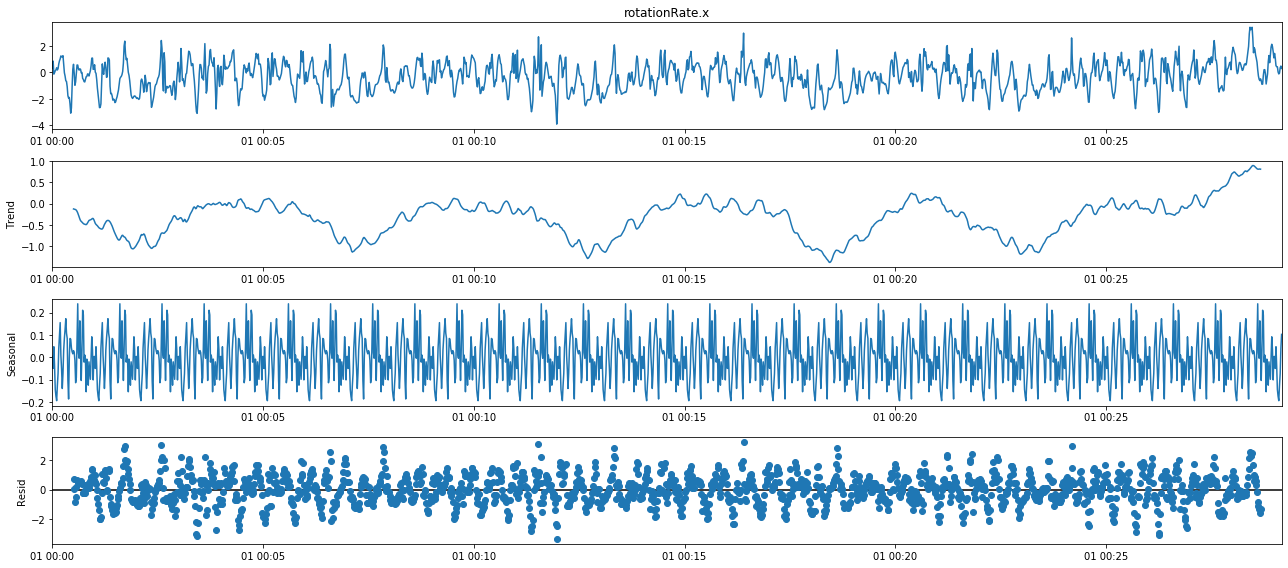

In [28]:
rcParams['figure.figsize'] = 18, 8


res = sm.tsa.seasonal_decompose(sensor['rotationRate.x'], freq=60)
resplot = res.plot()

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

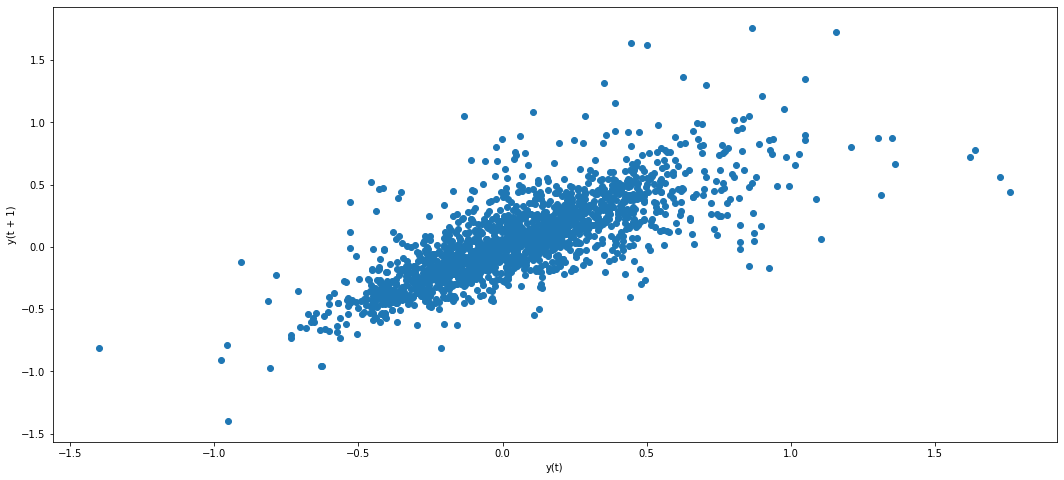

In [31]:
# Your code here:
rcParams['figure.figsize'] = 18, 8

lag_plot(sensor['userAcceleration.x'])

Create a lag plot for `rotationRate.x`

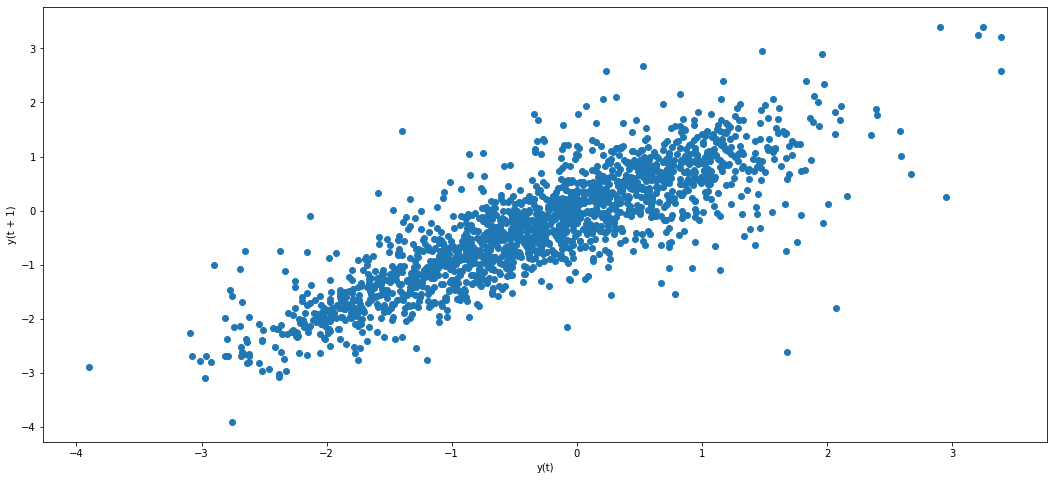

In [32]:
# Your code here:
rcParams['figure.figsize'] = 18, 8

lag_plot(sensor['rotationRate.x'])

What are your conclusions from both visualizations?

In [11]:
# Your conclusions here:

# Both visualizations show that Acceleration and Rotation are autocorrelated. 

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [42]:
# Your code here:

acceleration = adfuller(sensor['userAcceleration.x'])
rotation_rate = adfuller(sensor['rotationRate.x'])

print(f'pvalue for Acceleration is {acceleration[1]}')
print(f'pvalue for Rotation is {rotation_rate[1]}')

print('\n')

print(f'tstatistic for Acceleration is {acceleration[0]}')
print(f'tstatistic for Rotation is {rotation_rate[0]}')

print('\n')

for k, v in acceleration[4].items():
    print('\t{}:  {:.05} Los datos son {} estacionarios con {}% de confianza'.format(k, v, "not" if v < acceleration[0] else "", 100-int(k[:-1])))

print('\n')

for k, v in rotation_rate[4].items():
    print('\t{}:  {:.05} Los datos son {} estacionarios con {}% de confianza'.format(k, v, "not" if v < rotation_rate[0] else "", 100-int(k[:-1]))) 

pvalue for Acceleration is 2.823439483037483e-30
pvalue for Rotation is 6.320230335912249e-06


tstatistic for Acceleration is -17.957994086169748
tstatistic for Rotation is -5.26986062508642


	1%:  -3.4341 Los datos son  estacionarios con 99% de confianza
	5%:  -2.8632 Los datos son  estacionarios con 95% de confianza
	10%:  -2.5677 Los datos son  estacionarios con 90% de confianza


	1%:  -3.4341 Los datos son  estacionarios con 99% de confianza
	5%:  -2.8632 Los datos son  estacionarios con 95% de confianza
	10%:  -2.5677 Los datos son  estacionarios con 90% de confianza


What are your conclusions from this test?

In [13]:
# Your conclusions here:
# Both variables are stationary with various confidence %. 

Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [46]:
train , test = sensor['userAcceleration.x'][:-10] , sensor['userAcceleration.x'][-10:]

model = ARMA(sensor['userAcceleration.x'], order=(2, 1))
model_fit = model.fit(disp=False)
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) -1, dynamic=False)

df = pd.DataFrame({'Observed':test, 'Predicted':predictions})
df

/Users/alejandropalacios/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)


,Observed,Predicted
2018-01-01 00:29:01,0.149749,0.172776
2018-01-01 00:29:02,0.038461,0.115159
2018-01-01 00:29:03,-0.169175,-0.008270
2018-01-01 00:29:04,-0.300361,-0.186762
2018-01-01 00:29:05,-0.270174,-0.229210
2018-01-01 00:29:06,-0.268367,-0.136440
2018-01-01 00:29:07,-0.102444,-0.162658
2018-01-01 00:29:08,-0.085590,0.035719
2018-01-01 00:29:09,-0.048105,-0.043530
2018-01-01 00:29:10,-0.065011,0.008415


To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [54]:
# Your code here:
x1 = df['Observed']
x2 = df['Predicted']

print('Our model has a Root Mean Squared Error of {:02}.'.format(sm.tools.eval_measures.rmse(x1, x2, axis=0)))


Our model has a Root Mean Squared Error of 0.0938321696527326.
